# Machine Learning Lifecycle Project

## This is an exercise in 3 parts:
### A. Setup and Message Production
### B. Message Consumption and Storage
### C. Predictive Modeling with Machine Learning
$~$  
# A. Setup and Message Production
$~$

# 1. Installation

### Java JDK

Install Java JDK
https://www.oracle.com/technetwork/java/javase/downloads/jdk12-downloads-5295953.html

Set Java Environment Variables 
https://javatutorial.net/set-java-home-windows-10

### Kafka

Download and Unzip Kafka – Binary Version.
https://kafka.apache.org/downloads

Edit Kafka Properties
Go to config folder in Apache Kafka and edit server.properties using text editor if desired:

   Find log.dirs and replace path with preferred log location (C:\\Kafka\\Logs).

### PostgreSQL

Install Postgres

https://www.postgresql.org/download/windows/

password=postgres

port=5432


# 2. System Initialization

### Kafka
Notes:
Be sure to run command windows as administrator

My installation folder: kafka\kafka_2.11-2.2.0\bin\windows

#### Start Zookeeper

zookeeper-server-start.bat ..\..\config\zookeeper.properties - from bin/windows

#### Stop Zookeeper (only when needed)

zookeeper-server-stop.bat config/zookeeper.properties - from bin/windows

#### Start Kafka

kafka-server-start.bat ..\..\config\server.properties - from bin/windows

#### Stop Kafka (only when needed)

kafka-server-stop.bat config/server.properties - from bin/windows

#### Ensure Zookeeper and Kafka are Running

jps

You should see jps, QuorumPeerMain for zookeeper and kafka all listed

#### Create Topics

kafka-topics.bat --create --zookeeper localhost:2181 --topic RawData --partitions 1 --replication-factor 1

kafka-topics.bat --create --zookeeper localhost:2181 --topic Results --partitions 1 --replication-factor 1

### Helpful Scripts

#### List and Describe Topics

kafka-topics.bat --list --zookeeper localhost:2181

kafka-topics.bat --describe --zookeeper localhost:2181 --topic RawData

#### List and Describe Groups

kafka-consumer-groups.bat  -bootstrap-server localhost:9092 -list

kafka-run-class.bat kafka.admin.ConsumerGroupCommand --group GROUPNAME --bootstrap-server localhost:9092 --describe

#### See Messages in Console

kafka-console-consumer.bat --bootstrap-server localhost:9092 --topic RawData --from-beginning

kafka-console-consumer.bat --bootstrap-server localhost:9092 --topic Results --from-beginning

### PostgreSQL

#### Create Database
CREATE DATABASE messaging;

CONNECT messaging;

#### Create Tables
CREATE TABLE RawData(Key INTEGER PRIMARY KEY, X FLOAT(10) NOT NULL, Y FLOAT(10) NOT NULL);

CREATE TABLE Results(Key INTEGER PRIMARY KEY, Result BOOLEAN NOT NULL);

CREATE TABLE Predictions(Key INTEGER PRIMARY KEY, Prediction BOOLEAN);

CREATE TABLE predtemp(Key INTEGER PRIMARY KEY, Prediction BOOLEAN);

# 3. Key Parameters

In [893]:
#metric for label:
metric=0.0
#batch size:
size=1000

# 4. Validate PostgreSQL Connection 

In [894]:
#import packages
import pandas as pd 
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score 
import sys, os
import json
from time import sleep
from kafka import KafkaConsumer
from kafka import KafkaProducer
import psycopg2
import pandas.io.sql as psql
%matplotlib inline

In [895]:
#connect to PostgreSQL and confirm with version
conn_string = "host=localhost port=5432 dbname=messaging user=postgres password=postgres"
connection=psycopg2.connect(conn_string)
cursor = connection.cursor()
cursor.execute('SELECT version()')
db_version = cursor.fetchone()
print('PostgreSQL database version:',db_version)

PostgreSQL database version: ('PostgreSQL 11.2, compiled by Visual C++ build 1914, 64-bit',)


In [901]:
#request last record key from PostgreSQL
cursor = connection.cursor()
cursor.execute("select max(key) from RawData")
startkey = cursor.fetchone()
if startkey[0] == None:
    startkey = 0
else:
    startkey = int(startkey[0])
print(startkey,"= last key written to PostgreSQL")

13000 = last key written to PostgreSQL


# 5. Produce Data Messages

In [897]:
#establish kafka producer
producer = KafkaProducer(bootstrap_servers='localhost:9092', api_version=(0,10,1))

In [898]:
#json structure for message encoding
def create_RawData_json(key,x,y):
    return {
        'key': key,
        'x': x,
        'y': y,
    }

def create_Result_json(key,Results):
    return {
        'key': key,
        'result': result,
    }

In [899]:
#generate json messages, encode and send in loop 
key=startkey
RawDataList=[]
ResultsList=[]
for i in range(size):
    key=key+1
    x=np.random.rand()*2-1
    y=np.random.rand()*2-1
    z=np.random.rand()*.2-.1
    result=x*y+z>metric
    
    rawsample=create_RawData_json(key,x,y)
    message_RawData=json.dumps(rawsample)
    #print(message_RawData)
    producer.send('RawData', key=bytes(key), value=message_RawData.encode())
    
    rawresult=create_Result_json(key,result)
    message_Result=json.dumps(rawresult)
    #print(message_Result)
    producer.send('Results', key=bytes(key), value=message_Result.encode())
    
print(key-startkey,"Raw Data and Result messages produced in kafka")

5000 Raw Data and Result messages produced in kafka


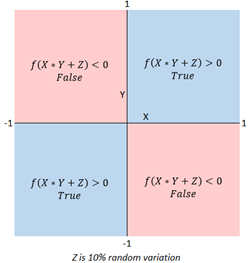

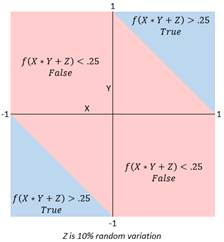

#### PostgreSQL Utility Code

In [900]:
#rollback on error break
#cursor = connection.cursor()
#cursor.execute(""" rollback;""")